# Ex11

In [1]:
! pip install --upgrade tensorflow==2.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install keras==2.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


### 데이터셋 구성하기

In [5]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [6]:
# train_x의 이미지를 -1, 1로 정규화

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


이미지를 잘 불러왔는지, 한 번 보자.

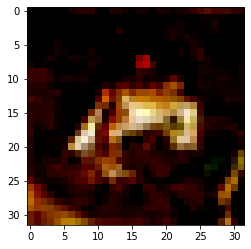

In [7]:
# 시각화
plt.imshow(train_x[0])
plt.show()

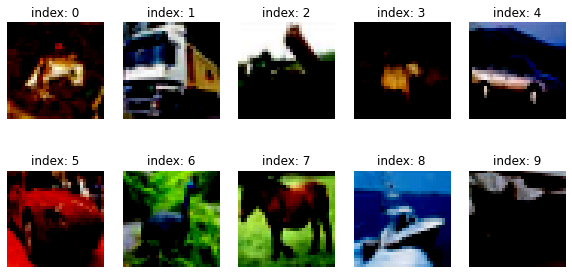

In [8]:
# 시각화
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

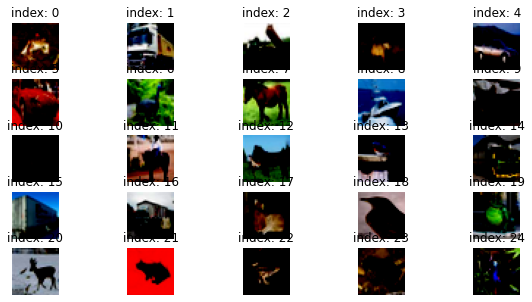

In [9]:
# 시각화
plt.figure(figsize=(10, 5))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [10]:
# 미니배치 데이터 셋

BUFFER_SIZE = 50000
BATCH_SIZE = 16
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### 생성자 모댈 구현하기

In [11]:
# define the standalone generator model
def make_generator_model():
    
    model = tf.keras.Sequential()
    # First: Dense layer
    model.add(layers.Dense(4*4*1024,  input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 1024)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')) 
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=3, padding='same', \
                                     activation='tanh'))

    return model

In [12]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1654784   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         2097280   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [13]:
noise = tf.random.normal([1, 100,])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

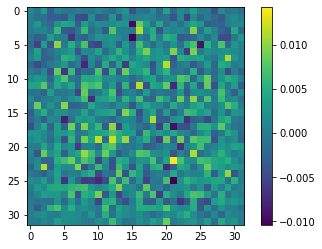

In [14]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

### 판별자 모델 구현하기

In [15]:
def make_discriminator_model3():
    
    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128,  kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dropout Layer
    model.add(layers.Dropout(0.2))

    # Fourth: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

In [16]:
discriminator = make_discriminator_model3()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        3136      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)             

In [17]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.50009197]], dtype=float32)>

### 손실함수와 최적화 함수

교차 엔트로피는 앞서 분류 모델을 설계할 때 많이 사용했던 손실함수이다. 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰인다. 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것이다.

그렇다면 Real Image에 대한 라벨을 1, Fake Image에 대한 라벨을 0으로 두었을 때, 각각의 손실함수를 이용해 정량적으로 달성해야 하는 목표하는 결과는 다음과 같다.



1. 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것

2. 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워 지는 것

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#### generator_loss, discriminator_loss

generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 된다. 즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가진다.

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

반면, discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두가지 loss값을 모두 계산한다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 된다.

최종 discriminator_loss 값은 이 둘을 더한 값이다.

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### discriminator accuracy

특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용하다.

만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까? 그렇지 않다. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻이다. 그래서, real accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻이다.

In [21]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

#### Optimizer

생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다.

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

샘플은 한 번에 16, 생성한 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이지를 만들어두어야 한다.

In [23]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### 훈련과정 상세 기능 구현

In [24]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

1. (1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
2. (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
3. (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
4. (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
5. (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
6. (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
7. (7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
8. (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
9. (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
10. (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [25]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]+1)/2)
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [26]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/training_history/train_history_{:04d}.png'
                    .format( epoch))
    plt.show()

In [27]:
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 학습 과정 진행하기

In [28]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)


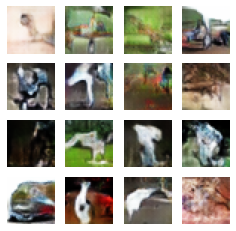

Time for training : 4265 sec


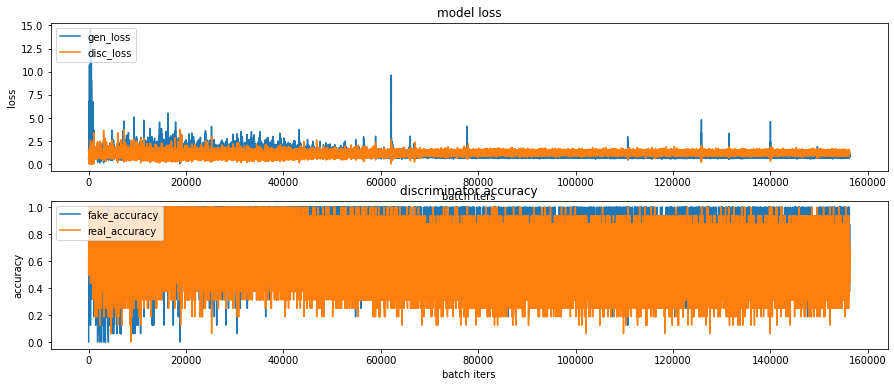

In [29]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

%time
train(train_dataset, EPOCHS, save_every)

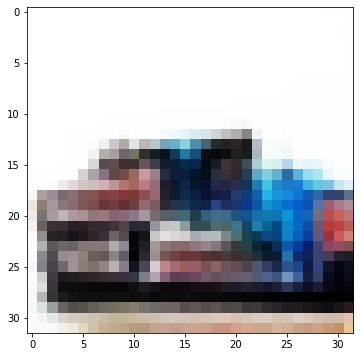

In [30]:
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

# 회고

낙관적인 기다림은 내편이 아니였다... 여러 방법으로 시도를 했지만, 결과가 너무 안 좋게 나온다. fake accuracy 우하향.. 조금이라도 내려가주기를 바랬지만 어림도 없었다. 무엇보다 과제를 성실하게 했더라면, epoch를 늘리는 시도도 해볼 수 있었을 것이다. 이럴 수 없다는 게 개탄스럽다. 다음 노드는 성실하게 임해야겠다고 생각이 든다.

그래도 이번 익스 부터는 참고하고 모델링을 진행해봤다. 교수님이 쌓는 것과 비슷하게 모델 층을 쌓았는데도 결과가 잘 나오지 않아 의아하면서도 슬펐다. 그래도 첫시도를 해봤다는 것에 대해 칭찬을 하고 싶다.

이제 노드를 학습할 때 여러번 봤던 내용이 나와 익숙하게 느껴진다. 아는 내용이 나올 때 마다 성장한 모습에 즐겁기도 하다. 하지만, 적용할 때 마다 좌절을 느낀다. 구현력....왜 항상 생각했던 결과와 반대로만 나오는 걸까...더욱 열심히 공부해야겠다.

여러명의 결과물을 종합해본 결과 epoch를 많이 늘린 사람들이 결과가 잘 나온 거 같다. 그래서 결국은 epoch 횟수는 신이다. 